In [304]:
import numpy as np
import string
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [305]:
def generate_almost_orthogonal_embeddings(k, D, seed=None):
    rng = np.random.default_rng(seed)
    vecs = rng.normal(size=(k, D))
    # Normalisation
    vecs = vecs / np.linalg.norm(vecs, axis=1, keepdims=True)
    return vecs.astype(np.float32)


In [306]:
def orthogonality_score(embeddings):
    dot_prods = embeddings @ embeddings.T
    np.fill_diagonal(dot_prods, 0)
    return np.max(np.abs(dot_prods))


In [307]:
R = 20

In [404]:
T = 20
k = 26
D = 500

In [405]:
embeddings = generate_almost_orthogonal_embeddings(1+k+T, D//2, seed=0)

In [406]:
def generate_dict(k, D):
    assert D % 2 == 0, "D doit être divisible par 2"
    letters = list(string.ascii_uppercase)
    assert k <= len(letters), "k ne doit pas dépasser 26"

    dico = {}

    # Ajout du token 'b' (begin)
    begin_half = embeddings[0]
    begin_vec = np.concatenate([begin_half, np.zeros(D // 2, dtype=np.float32)])
    dico['b'] = begin_vec

    # Ajout des k lettres
    for i in range(k):
        key = letters[i]
        half = embeddings[i + 1]
        vec = np.concatenate([half, np.zeros(D // 2, dtype=np.float32)])
        dico[key] = vec

    return dico

In [407]:
dic = generate_dict(k, D)

In [408]:
dic['C'] @ dic['C'].T

1.0

In [409]:
def string_to_token(s):
    return np.array([dic[c] for c in s]).astype(np.float32)

In [410]:
def softmax(x, axis=None):
    x_max = np.max(x, axis=axis, keepdims=True)
    e_x = np.exp(x - x_max)
    return e_x / np.sum(e_x, axis=axis, keepdims=True)

In [411]:

string_seq = ['b', 'C', 'A', 'E', 'C', 'H', 'E', 'A', 'A', 'D', 'B', 'H']
T = len(string_seq)

In [412]:
P = np.zeros((T, D), dtype=np.float32)
for i in range(T):
    half = embeddings[k + i + 1]
    P[i] = np.concatenate([half, np.zeros(D // 2, dtype=np.float32)])

In [413]:
P.shape

(12, 500)

In [414]:
P[0] @ P[1].T

0.023900952

In [415]:
def permutation_matrix(D):
    assert D % 2 == 0, "D doit être pair"
    d_half = D // 2
    V = np.zeros((D, D))

    # Remplit les blocs pour permuter les deux moitiés
    V[:d_half, d_half:] = np.eye(d_half)  # Haut droit
    V[d_half:, :d_half] = np.eye(d_half)  # Bas gauche

    return V

In [416]:
def embedding(P, S):
    T = S.shape[0]
    return P[:T,:]+S

In [417]:
def first_layer(P, S):
    X = embedding(P, S)
    QK1 = np.zeros((D,D), dtype=np.float32)
    for i in range(1, len(P)):
        QK1 = QK1 + (P[i].reshape(D, 1) @ P[i-1].reshape(1, D))
    
    Att = X @ QK1 @ (X.T)/ np.linalg.norm(X @ QK1 @ (X.T)) * 20
    Att = softmax(Att, axis=1)
    V = permutation_matrix(D)
    Z = (Att @ X @ V)/np.linalg.norm(Att @ X @ V)+X/np.linalg.norm(X)
    return Att, Z

In [418]:
Att1, Z1 = first_layer(P, string_to_token(string_seq))
Z1

array([[-0.00056179, -0.00206899,  0.00646092, ...,  0.01583318,
        -0.01031728, -0.00556557],
       [ 0.03327147,  0.02049373,  0.0234551 , ...,  0.02661166,
         0.00203651, -0.02019414],
       [ 0.01469886,  0.02095146,  0.02748775, ...,  0.00760427,
         0.00304497, -0.00842324],
       ...,
       [-0.00027073,  0.01289043,  0.00501882, ...,  0.00027157,
        -0.0223196 , -0.01567765],
       [ 0.01637411, -0.00223037, -0.00415701, ...,  0.04150429,
         0.01177777, -0.00508399],
       [ 0.00819992, -0.02237055, -0.01624732, ..., -0.01151979,
         0.01655926,  0.00268862]])

In [419]:
def display_matrix(Att, string_seq):
    plt.figure(figsize=(8, 6))
    sns.heatmap(Att, annot=True, fmt=".2f", cmap="viridis",
                xticklabels=string_seq, yticklabels=string_seq)
    plt.title("Attention Matrix")
    plt.xlabel("Key")
    plt.ylabel("Query")
    plt.show()


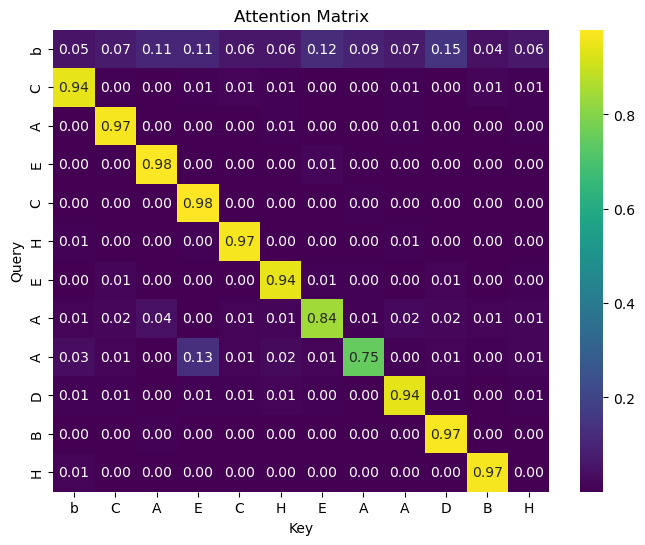

In [420]:
display_matrix(Att1, string_seq)

In [421]:
R = D//2

In [422]:
def second_layer(Z, beta=1):
    K_2 = np.zeros((D, D), dtype=np.float32)
    #K_2[:D//2, D//2:] = np.eye(D//2)  
    K_2[:R, D//2:D//2+R] = np.eye(R)  
    Att2 = Z @(K_2) @ (Z.T) *100
    Att2 = softmax(Att2, axis=1)
    V2 = beta* np.eye(D)
    Z2 = (Att2 @ Z @ V2)/np.linalg.norm(Att2 @ Z)
    return Att2, Z2


In [423]:
Att2, Z2 = second_layer(Z1)

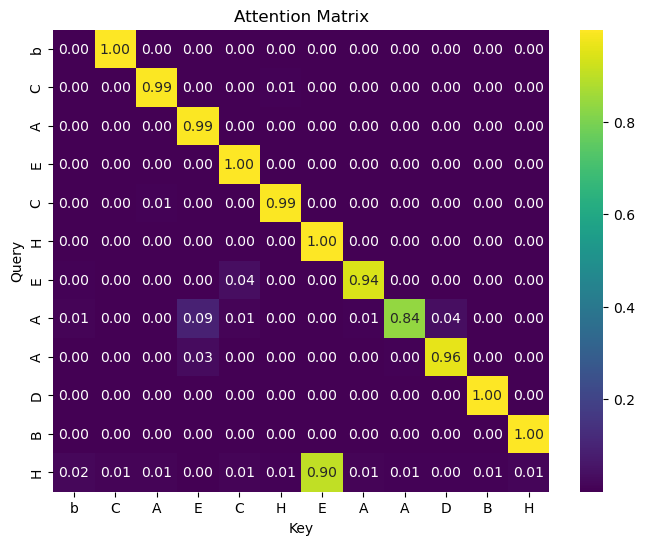

In [424]:
display_matrix(Att2, string_seq)

In [425]:
def classification(k, dico, Z):
    mlp = np.zeros((k, D), dtype=np.float32)
    letters = list(string.ascii_uppercase)
    for i in range(k):
        key = letters[i]
        mlp[i] = dico[key] *30
    logits = mlp @ Z[-1].T
    return softmax(logits)
    

In [426]:
classification_result = classification(k, dic, Z2)
print("Classification result", classification_result)

Classification result [0.02031405 0.01765787 0.01484965 0.02153325 0.55783375 0.01799631
 0.01599981 0.01491536 0.02246999 0.03097021 0.00759484 0.00736102
 0.02058822 0.02408599 0.01687597 0.01750781 0.01636706 0.01833223
 0.01141364 0.0217629  0.02128845 0.01554986 0.01593113 0.01648097
 0.01613951 0.01818018]


In [427]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import string

def plot_output(output, k):
    letters = list(string.ascii_uppercase[:k])
    df = pd.DataFrame({'Lettre': letters, 'Probabilité': output})

    plt.figure(figsize=(8, 4))
    sns.barplot(data=df, x='Lettre', y='Probabilité')
    plt.title("Distribution des probabilités (softmax)")
    plt.ylim(0, 1)
    plt.grid(True, axis='y', linestyle='--', alpha=0.5)
    plt.show()


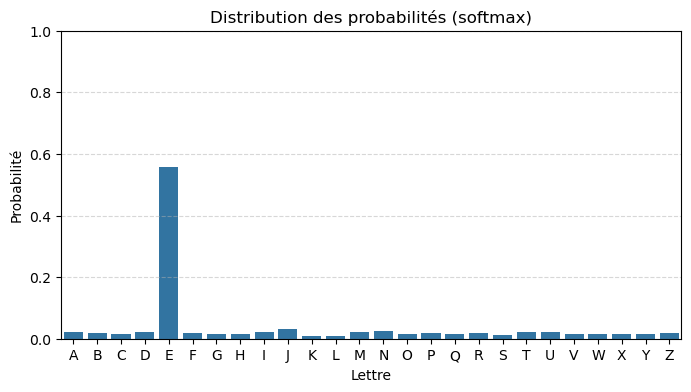

In [428]:
plot_output(classification_result, k)

In [429]:
def generate_X_y(T, dico, n):
    """
    Génère n séquences (X, y) :
    - X est une séquence de T+1 lettres : 'b', ..., target (qui apparaît deux fois)
    - y est la lettre juste après la première apparition du target
    """
    assert 'b' in dico
    letters = [k for k in dico if k != 'b']
    assert len(letters) >= 2
    assert T >= 3, "T doit être au moins 3 pour que target puisse apparaître avant la fin et être suivi"

    X_list = []
    y_list = []

    for _ in range(n):
        seq = ['b']
        target = random.choice(letters)

        # Position du target dans le corps, garanti < T - 1
        insert_pos = random.randint(1, T - 2)

        middle_letters = []
        for i in range(1, T):
            if i == insert_pos:
                middle_letters.append(target)
            else:
                other_choices = [l for l in letters if l != target]
                middle_letters.append(random.choice(other_choices))

        seq.extend(middle_letters)
        seq.append(target)  # target en dernière position

        y = middle_letters[insert_pos]
        X_list.append(seq)
        y_list.append(y)

    return X_list, y_list


In [430]:
def model(S):
    Att1, Z1 = first_layer(P, S)
    Att2, Z2 = second_layer(Z1)
    logits = classification(k, dic, Z2)
    return logits

In [431]:
P.shape, string_to_token(string_seq).shape

((12, 500), (12, 500))

In [432]:
model(string_to_token(string_seq))

array([0.02031405, 0.01765787, 0.01484965, 0.02153325, 0.55783375,
       0.01799631, 0.01599981, 0.01491536, 0.02246999, 0.03097021,
       0.00759484, 0.00736102, 0.02058822, 0.02408599, 0.01687597,
       0.01750781, 0.01636706, 0.01833223, 0.01141364, 0.0217629 ,
       0.02128845, 0.01554986, 0.01593113, 0.01648097, 0.01613951,
       0.01818018])

In [433]:
import numpy as np

def display_predictions_numpy(X_seq, y_true, model, char_to_int, int_to_char):
    """
    X_seq : liste de séquences de lettres (n x (T+1))
    y_true : liste de lettres (n)
    model  : fonction prenant S (n, T+1) indices → logits (n, k)
    Retourne l'affichage coloré dans le terminal.
    """
    error = 0
    BLUE  = '\033[94m'
    GREEN = '\033[92m'
    RESET = '\033[0m'

    # Conversion une fois des séquences en indices
    S_list = [string_to_token(x) for x in X_seq]  # shape (n, T+1)

    for i, S in enumerate(S_list):
        logits = model(S)             # shape (1, k) ou (k,)
        # si model renvoie (1,k), on aplatit :
        logits = logits.flatten()
        y_pred_idx = np.argmax(logits)
        pred_letter = int_to_char[y_pred_idx+1]
        true_letter = y_true[i]

        x_letters = X_seq[i]
        last = x_letters[-1]
        # trouver position unique de last dans le préfixe (sans compter b)
        other_pos = next(j for j, c in enumerate(x_letters[1:-1], start=1) if c == last)

        # marquer la séquence
        colored = []
        for j, c in enumerate(x_letters[1:], start=1):  # on ignore le 'b' à j=0
            if j == other_pos or j == len(x_letters)-1:
                # soit la première occurrence du last, soit la dernière
                colored.append(f"{BLUE}{c}{RESET}")
            elif c == true_letter:
                colored.append(f"{GREEN}{c}{RESET}")
            else:
                colored.append(c)

        print(f"Sequence : {''.join(colored)}")
        print(f"  True : {GREEN}{true_letter}{RESET}, Predicted : {GREEN}{pred_letter}{RESET}")

        # compter les erreurs
        if logits.max() < 0.5 or pred_letter != true_letter:
            error += 1

    print(f"\nErreur : {error} / {len(X_seq)} séquences")


In [434]:
T=10
X_seq, y = generate_X_y(T=T, dico=dic, n=30)


In [435]:
char_to_int = {c: i for i, c in enumerate(dic)}
int_to_char = {i: c for c, i in char_to_int.items()}


display_predictions_numpy(X_seq[:30], y, model, char_to_int, int_to_char)


Sequence : GEVFINPDBG
  True : E, Predicted : E
Sequence : PBYQTHEULY
  True : Q, Predicted : Q
Sequence : BAMQILJLQA
  True : M, Predicted : M
Sequence : CBWBKZTRXC
  True : B, Predicted : B
Sequence : MPKGIRRYQP
  True : K, Predicted : K
Sequence : LQNLJXDCBD
  True : C, Predicted : C
Sequence : FZCBNBLZFC
  True : B, Predicted : B
Sequence : YZAVMBOCJA
  True : V, Predicted : V
Sequence : IEWHNSPKMN
  True : S, Predicted : S
Sequence : GULHNPSFOS
  True : F, Predicted : F
Sequence : GIOJYCAFYG
  True : I, Predicted : I
Sequence : KLZURBQJJR
  True : B, Predicted : B
Sequence : HHVFAIOMCV
  True : F, Predicted : F
Sequence : HWLJKXGCCX
  True : G, Predicted : G
Sequence : XIQTUJZWHQ
  True : T, Predicted : T
Sequence : YQDBNAHBSY
  True : Q, Predicted : Q
Sequence : ORUZLYFMKF
  True : M, Predicted : M
Sequence : QYXHIJSNIH
  True : I, Predicted : I
Sequence : VSIOXXCKCI
  True : O, Predicted : O
Sequence : GLWFZVSAHA
  True : H, Predicted : H
Sequence : BMFZEIWDZE
  True : I, Predic

In [436]:
X_seq, y = generate_X_y(T=T, dico=dic, n=3000)

In [437]:
X_token = [string_to_token(x) for x in X_seq]  # shape (n, T+1)
X_token = np.array(X_token, dtype=np.float32)  # shape (n, T+1, D)
X_token.shape, X_token.dtype

((3000, 11, 500), dtype('float32'))

In [438]:
y_data = np.array([char_to_int[c]-1 for c in y], dtype=np.int32)  # shape (n,)
y_data

array([22, 22, 18, ..., 22,  2, 25], dtype=int32)

In [439]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch
import torch.nn as nn

In [464]:

class AttentionOnlyBlock(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.Wq = nn.Linear(d_model, d_model, bias=False)
        self.Wk = nn.Linear(d_model, d_model, bias=False)
        self.Wv = nn.Linear(d_model, d_model, bias=False)
        self.norm = nn.LayerNorm(d_model)
        self.attn_weights = None  # <-- pour garder la dernière attention

    def forward(self, x):
        Q = self.Wq(x)
        K = self.Wk(x)
        V = self.Wv(x)
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / (Q.size(-1) ** 0.5)
        attn_weights = F.softmax(attn_scores, dim=-1)
        self.attn_weights = attn_weights.detach().cpu()  # stocker pour affichage

        attn_output = torch.matmul(attn_weights, V)
        return self.norm(attn_output + x)


In [465]:
class AttentionOnlyTransformer(nn.Module):
    def __init__(self, d_model=2000, nhead=1, num_layers=2, num_classes=26, max_len=11):
        super().__init__()
        self.positional_encoding = nn.Parameter(torch.randn(1, max_len, d_model))
        self.blocks = nn.ModuleList([
            AttentionOnlyBlock(d_model) for _ in range(num_layers)
        ])
        self.classifier = nn.Linear(d_model, num_classes)

    def forward(self, x):  # x: (B, T, D)
        x = x + self.positional_encoding[:, :x.size(1), :]
        for block in self.blocks:
            x = block(x)
        last_token = x[:, -1, :]  # utiliser la sortie du dernier token
        return self.classifier(last_token)  # (B, num_classes)


In [466]:
X_tensor = torch.tensor(X_token, dtype=torch.float32)  # (30, 11, 2000)
y_tensor = torch.tensor(y_data, dtype=torch.long)  

In [467]:
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)


train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=320, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

In [468]:
model = AttentionOnlyTransformer(d_model=D, nhead=1, num_layers=2, num_classes=k, max_len=T+1)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [469]:
P_copy = P[:T+1].copy()

In [470]:
V1 = permutation_matrix(D)  
attn_layer1 = model.blocks[0]

W_k1 = np.eye(D, dtype=np.float32)

W_v1 = V1.astype(np.float32)

QK1 = np.zeros((D,D), dtype=np.float32)
for i in range(1, len(P)):
    QK1 = QK1 + (P[i].reshape(D, 1) @ P[i-1].reshape(1, D))
W_q1 = QK1.astype(np.float32).T *100



with torch.no_grad():
    attn_layer1.Wq.weight.data.copy_(torch.tensor(W_q1))
    attn_layer1.Wk.weight.data.copy_(torch.tensor(W_k1))
    attn_layer1.Wv.weight.data.copy_(torch.tensor(W_v1))
    attn_layer1.Wv.weight.requires_grad = False
    attn_layer1.Wq.weight.requires_grad = False
    attn_layer1.Wk.weight.requires_grad = False


In [476]:
K_2 = np.zeros((D, D), dtype=np.float32)
#K_2[:D//2, D//2:] = np.eye(D//2)  
K_2[:R, D//2:D//2+R] = np.eye(R)
K_2 = K_2.astype(np.float32)
Q_2 = np.eye(D, dtype=np.float32)
V2 = np.eye(D, dtype=np.float32)

attn_layer2 = model.blocks[1]
W_q2 = Q_2.astype(np.float32)
W_k2 = K_2.astype(np.float32)
W_v2 = V2.astype(np.float32)



with torch.no_grad():
    attn_layer2.Wq.weight.data.copy_(torch.tensor(W_q2))
    attn_layer2.Wk.weight.data.copy_(torch.tensor(W_k2))
    attn_layer2.Wv.weight.data.copy_(torch.tensor(W_v2))
    attn_layer2.Wv.weight.requires_grad = False
    attn_layer2.Wq.weight.requires_grad = False
    attn_layer2.Wk.weight.requires_grad = False

In [477]:
with torch.no_grad():
    # Initialiser les poids de la couche d'attention avec P_copy
    model.positional_encoding.copy_(torch.tensor(P_copy.reshape(1, T+1, D), dtype=torch.float32))
    model.positional_encoding.requires_grad = False

In [ ]:
for epoch in range(10):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for xb, yb in train_loader:
        optimizer.zero_grad()
        outputs = model(xb)  # (B, 27)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * xb.size(0)
        correct += (outputs.argmax(dim=1) == yb).sum().item()
        total += xb.size(0)

    train_acc = correct / total
    train_loss = total_loss / total

    # ---------- Évaluation ----------
    model.eval()
    with torch.no_grad():
        for xb, yb in test_loader:
            outputs = model(xb)
            test_loss = criterion(outputs, yb).item()
            test_acc = (outputs.argmax(dim=1) == yb).float().mean().item()

    if epoch % 2 == 0:
        print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f}")

In [479]:
end = 5
X_plot = X_tensor[:end]
y_plot = y_tensor[:end]

Sequence : ['b', 'M', 'R', 'P', 'R', 'T', 'F', 'D', 'X', 'W', 'X']
  True : W, Predicted : O
0 0
0 1
Sequence : ['b', 'L', 'Q', 'N', 'I', 'W', 'X', 'F', 'D', 'E', 'I']
  True : W, Predicted : G
1 0
1 1
Sequence : ['b', 'G', 'B', 'W', 'K', 'S', 'X', 'H', 'G', 'F', 'K']
  True : S, Predicted : G
2 0
2 1
Sequence : ['b', 'B', 'Y', 'V', 'N', 'X', 'P', 'A', 'E', 'F', 'V']
  True : N, Predicted : Z
3 0
3 1
Sequence : ['b', 'M', 'L', 'D', 'S', 'P', 'C', 'A', 'O', 'D', 'C']
  True : A, Predicted : Z
4 0
4 1


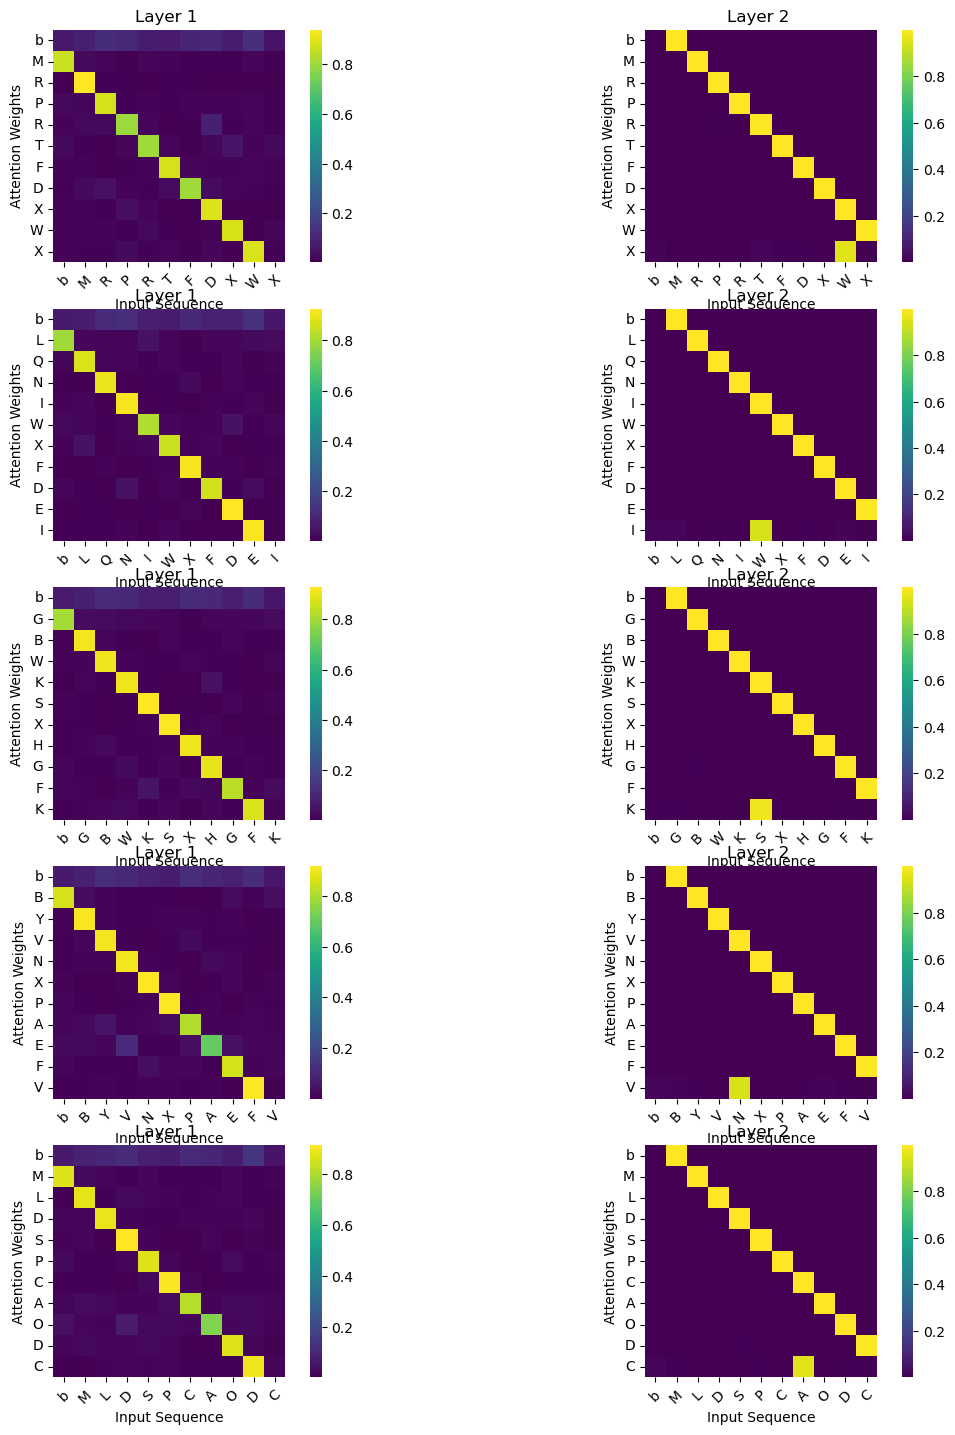

In [480]:
def plot_attention_matrix(model, X_plot, y_plot, char_to_int, int_to_char):
    model.eval()
    num_sequences = len(X_plot) 
    fig, axs = plt.subplots(num_sequences, 2, figsize=(14, 3.5 * num_sequences))
    with torch.no_grad():

        for i in range(len(X_plot)):
            attn_weights = []
            x = X_plot[i:i+1]
            y = y_plot[i:i+1]

            logits = model(x)
            pred_idx = logits.argmax(dim=1).item()
            pred_letter = int_to_char[pred_idx+1]
            true_letter = int_to_char[y.item()+1]

            print(f"Sequence : {X_seq[i]}")
            print(f"  True : {true_letter}, Predicted : {pred_letter}")
            for j in range(len(model.blocks)):
                attn_weights.append(model.blocks[j].attn_weights)

            for j, attn in enumerate(attn_weights):
                print(i,j)
                sns.heatmap(attn[0].cpu().numpy(), cmap="viridis",
                            xticklabels=X_seq[i],
                            yticklabels=X_seq[i], ax=axs[i, j],
                            square=True)
                axs[i][j].set_title(f"Layer {j + 1} ")
                axs[i][j].set_xlabel("Input Sequence")
                axs[i][j].set_ylabel("Attention Weights")
                axs[i][j].set_xticklabels(X_seq[i], rotation=45)
                axs[i][j].set_yticklabels(X_seq[i], rotation=0)
plot_attention_matrix(model, X_plot, y_plot, char_to_int, int_to_char)